In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))

import tensorflow_datasets as tfds
import tensorflow as tf
from src.data import make_datasets
from src.models import build_unet_model
from src.utils import display_sample, create_mask, show_predictions
from IPython.display import clear_output

In [2]:
DATASET_NAME = 'oxford_iiit_pet:4.0.0'
dataset, info = tfds.load(DATASET_NAME, with_info=True)
print('Dataset cargado:', DATASET_NAME)

Dataset cargado: oxford_iiit_pet:4.0.0


In [3]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64 
BUFFER_SIZE = 1000 # Buffer size for shuffling the dataset
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE # Number of steps per epoch
TRAIN_LENGTH, STEPS_PER_EPOCH

(3680, 57)

In [4]:
train_batches, test_batches, info = make_datasets(DATASET_NAME, BATCH_SIZE,BUFFER_SIZE,True)

In [5]:
OUTPUT_CLASSES = 3 # Número de clases en la segmentación

model = build_unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              # Usamos SparseCategoricalCrossentropy pq hay mas de 2 clases, sino se usaria BinaryCrossentropy
              # Sparse significa que las etiquetas son enteros en lugar de one-hot encoded
              # Logits=True porque la salida del modelo no ha pasado por una función de activación softmax
              metrics=['accuracy'])

# Para los barcos
# OUTPUT_CLASSES = 1
# Loss: BinaryCrossentropy(from_logits=True)

#tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=True)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 242ms/step


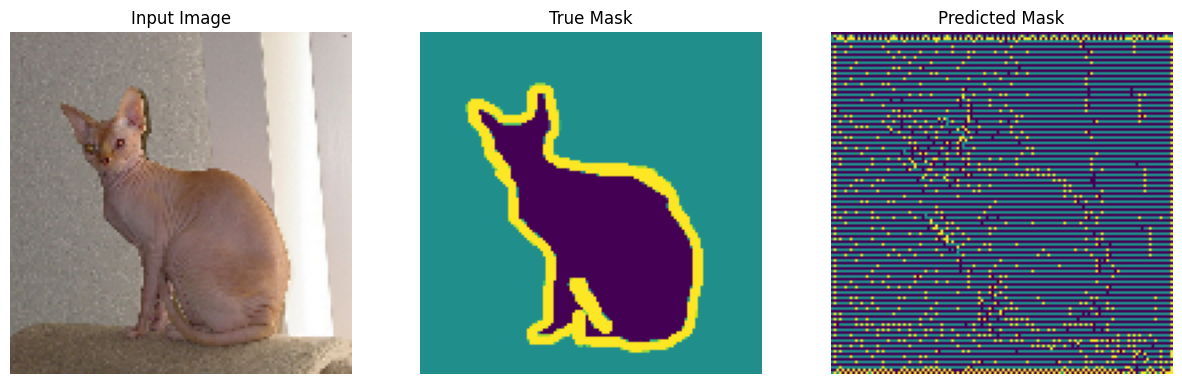

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 252ms/step


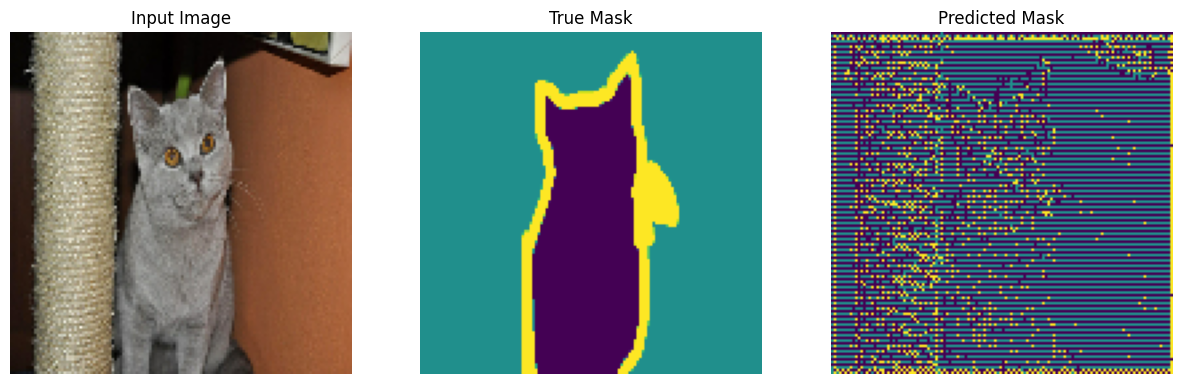

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


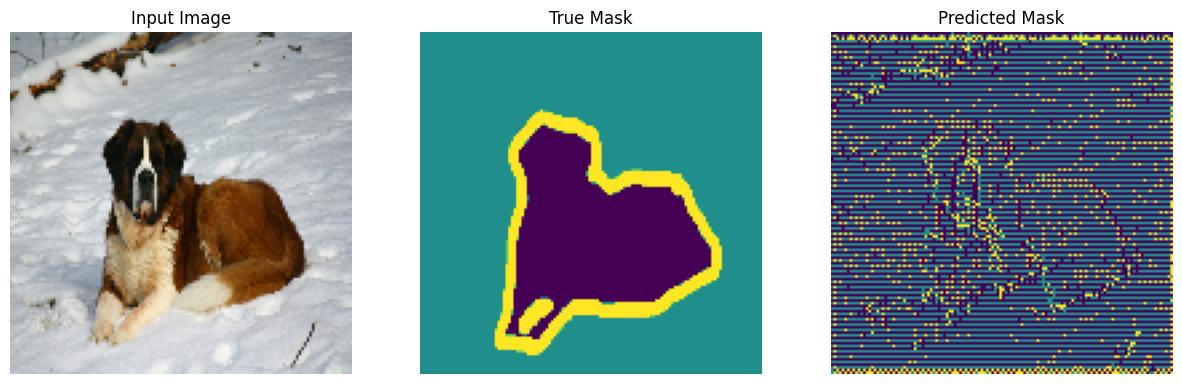

In [6]:
show_predictions(model, dataset=train_batches, num=3)

In [7]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def __init__(self, dataset):
    super().__init__()
    self.dataset = dataset

  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions(model=self.model, dataset=self.dataset, num=1)
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


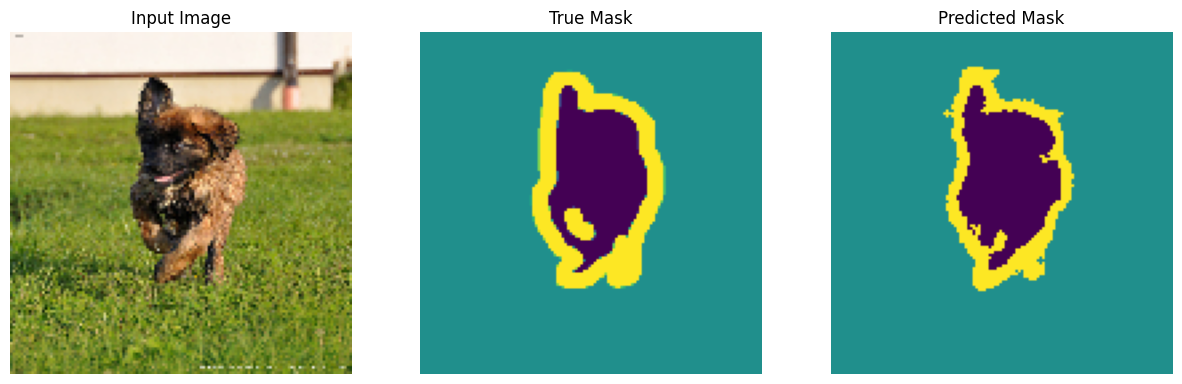


Sample Prediction after epoch 20

57/57 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.9190 - loss: 0.1828 - val_accuracy: 0.8925 - val_loss: 0.2779


In [8]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback(test_batches)])